In [97]:
!pip install opencv-python
!pip install cmake
!pip install dlib


In [66]:
#라이브러리 불러오기
import cv2
import matplotlib.pyplot as plt
import numpy as np

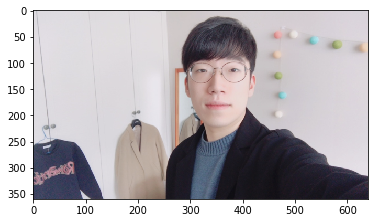

In [67]:
#이미지 불러오기
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [68]:
#hog detector 실행
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

rectangles[[(270, 64) (425, 219)]]


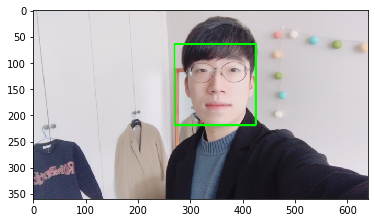

In [69]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

#Object keypoint estimation 
#Top-down : bounding box > keypoint 
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [70]:
#Dlib weight file 
#load landmark
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [71]:
#dlib.full_object_detction 리턴
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0])) #  tuple (x, y) 68

68


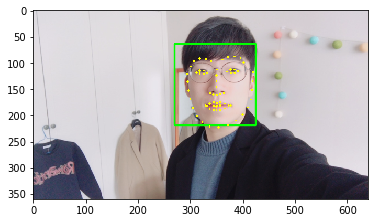

In [72]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [73]:
#스티커를 씌울 좌표 계산
#랜드마크 기준으로 코 중심에서 x높이 이상 
# 혹은 눈썹위 n 픽셀 위에 구현 가능
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))#스티커를 그려나갈 중심 좌표값
    print ('(w,h) : (%d,%d)'%(w,h))#스티커의 크기

(350, 146)
(x,y) : (350,68)
(w,h) : (156,156)


In [74]:
#스티커 이미지에 적용
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape) 

(156, 156, 3)


In [75]:
#이미지 시작점은 top-left
#스티커 추가를 위한 좌표갑 조정
refined_x = x - w // 2  # left
refined_y = y - h       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (272,-88)


In [76]:
#이미지 영역을 벗어난만큼 스티커 이미지 크롭하기
img_sticker = img_sticker[refined_y:]
print (img_sticker.shape)

(88, 156, 3)


In [77]:
#y값을 원본 이미지의 경계값으로 수정 
refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (272,0)


In [78]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], 
                        refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0],
         refined_x:refined_x+img_sticker.shape[1]] = \
np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

In [79]:
#스티커 이미지에서 사용할 부분은 색이 있는 부분
#따라서 img_sticker 가 0 인 부분은 sticker_area
#0이 아닌 부분을 img_sticker로 사용

print(refined_y)
print(refined_x)
print(img_sticker.shape[0])
print(img_sticker.shape[1])
print(refined_y+img_sticker.shape[0])
print(refined_x+img_sticker.shape[1])

0
272
88
156
88
428


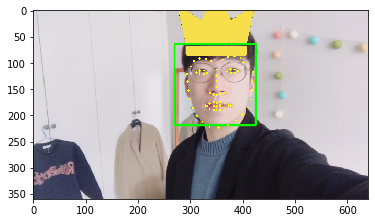

In [80]:
#테스트 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

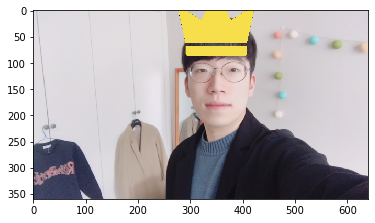

In [81]:
#최종 결과물 출력
#bounding box , landmark 제거
#img_show > img_rgb
sticker_area = img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

In [107]:
cat_sticker = cat_sticker[refined_y:]
print (cat_sticker.shape)

(156, 156, 4)


In [139]:
#고양이 스티커 위치 계산
#고양이 수염 위치는 2,36,48,30 번 인덱스 사용
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 중심
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(350, 146)
(x,y) : (350,-10)
(w,h) : (156,156)


(156, 156, 4)


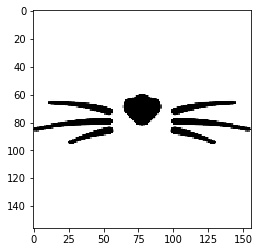

In [149]:
#고양이 수염 이미지 불러오기
import os

cat_sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
cat_sticker = cv2.imread(cat_sticker_path, cv2.IMREAD_UNCHANGED); #배경을 투명으로 
cat_sticker2 = cv2.resize(cat_sticker, (w,h))
print (cat_sticker2.shape)
plt.imshow(cat_sticker2);

In [164]:
#좌표 수정
refined_x = x - w // 2  # left
refined_y = y - h       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (272,-166)


In [165]:
#스티커 좌표값 수정
cat_sticker2 = cat_sticker2[refined_y:]
print (cat_sticker2.shape)

(30, 156, 4)


In [166]:
refined_y = -30
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (272,-30)


In [167]:
sticker_area = img_show[refined_y:cat_sticker.shape[0],
                        refined_x:refined_x+cat_sticker2.shape[1]]
img_show[refined_y:cat_s|ticker2.shape[0], 
         refined_x:refined_x+cat_sticker2.shape[1]] = \
    np.where(cat_sticker==0,cat_sticker2,cat_sticker2).astype(np.uint8)

ValueError: operands could not be broadcast together with shapes (512,512,4) (30,156,4) (30,156,4) 

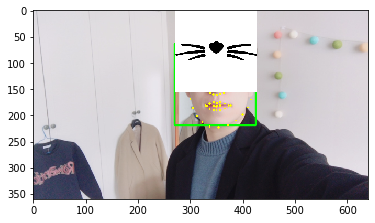

In [168]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

In [171]:
sticker_area = img_bgr[refined_y:cat_sticker2.shape[0], refined_x:refined_x+cat_sticker2.shape[1]]
img_bgr[refined_y:cat_sticker2.shape[0], refined_x:refined_x+cat_sticker2.shape[1]] = \
    np.where(cat_sticker2==0,cat_sticker2,cat_sticker2).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

ValueError: could not broadcast input array from shape (30,156,4) into shape (0,156,3)